In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import count
import pickle
import sys
sys.path.append('../..')
import brian_utils.postproc as bup
from brian2 import *

In [4]:
path = '/research/harris/prebot_opioid_model'

### Panel A

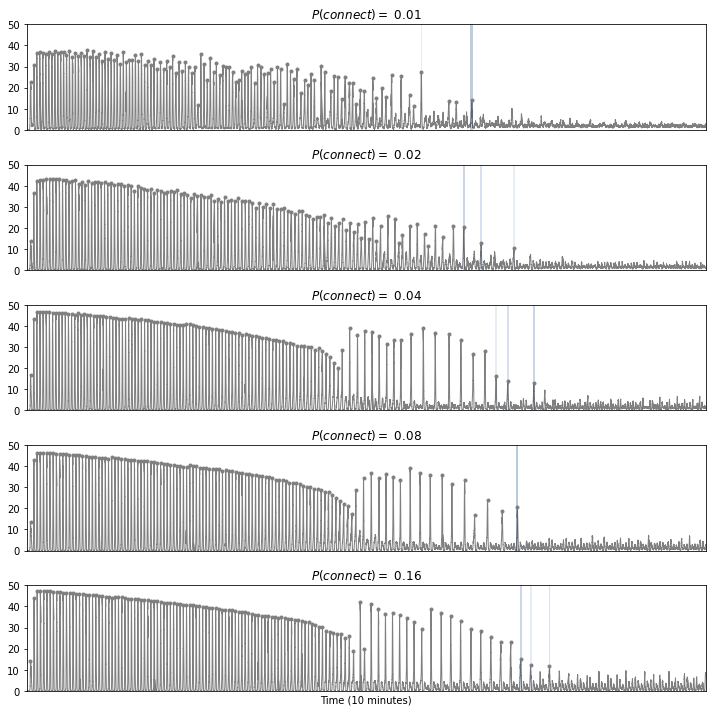

In [35]:
# plot 5 traces, one per connection probability
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True, sharey=True)
pcons = [0.01,0.02,0.04,0.08,0.16]
run_seed = 1 # this seed has ~average shutdown value for P(Connection) = 0.01
i = 0
for p in pcons:
    with open(f'{path}/data/damgo_ramp_pkls/pcon_{p}/seed{run_seed}-damgo_ramp_pcon_{p}_vars.pkl','rb') as fid1:
        data = pickle.load(fid1)
    rate1 = data['ratemonitor']

    binsize = 25 * ms 
    smoothed_pop_rate = bup.smooth_saved_rate(rate1, binsize)
    burst_stats = bup.pop_burst_stats(rate1['t'], smoothed_pop_rate, height = 4, prominence = 10)

    # mark burst peaks
    ax[i].plot(rate1['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
#         ax[i].set_xlabel('Time (s)')
#         ax[i].set_ylabel('FR\n(Hz/cell)')
    ax[i].set_xticks([])
    ax[i].set_xlim(0,600)
    ax[i].set_ylim(0,50)
    ax[i].set_title(rf'$P(connect) =$ {pcons[i]}')
    for thresh in range(10,16):
        ax[i].axvspan(burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Onset Times'], burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Offset Times'], color='lightsteelblue', alpha=0.3, lw=0)
    ax[i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c='tab:gray')
    i+=1
ax[4].set_xlabel('Time (10 minutes)')

plt.tight_layout()
plt.savefig('fig3_traces.pdf')

### Panel B

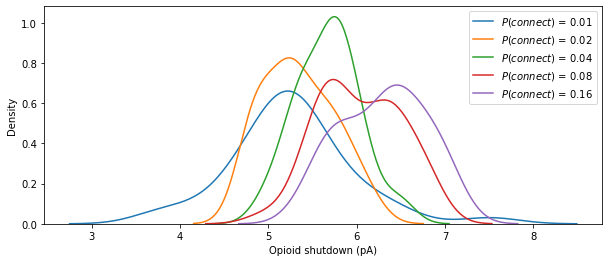

In [25]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
pcons = [0.01,0.02,0.04,0.08,0.16]
for p in pcons:
    df = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_{p}.csv', usecols=['run_seed', 'I_opioid_shutdown'])
    sns.kdeplot(df['I_opioid_shutdown'], ax=ax, label=rf'$P(connect)$ = {p}')
    
ax.set_xlabel('Opioid shutdown (pA)')
ax.legend()
plt.savefig('fig3_shutdown_distr.pdf')

### Panel C

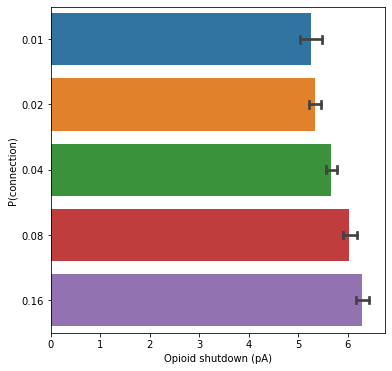

In [33]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
df1 = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_0.01.csv', usecols=['run_seed', 'I_opioid_shutdown'])
df1['P(connection)'] = str(0.01)
for p in pcons[1:]:
    df2 = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_{p}.csv', usecols=['run_seed', 'I_opioid_shutdown'])
    df2['P(connection)'] = str(p)
    df1 = pd.concat([df1,df2])
    
sns.barplot(data=df1, x='I_opioid_shutdown', y='P(connection)', capsize=0.1, ax=ax)
ax.set_xlabel('Opioid shutdown (pA)')
plt.savefig('fig3_barplot.pdf')